In [6]:
# Dependencies
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
from modules.dataset.tweets import Tweets 
from modules.dataset.entities import Entities

%matplotlib inline

In [7]:
# Paths
TWEETS_RAW_PATH = 'data/tweets.jsonl'
TWEETS_DB_PATH = 'data/db/tweets.json'
HASHTAGS_DB_PATH = 'data/db/hashtags.json'
WORDS_DB_PATH = 'data/db/words.json'
SUBS_HASHTAGS_PATH = 'data/hashtag_subs.json'
SUBS_CONTRACT_PATH = 'data/contract_forms.json'

In [8]:
# States wether to overvrite dataset with a new one
OVERWRITE = False

In [9]:
# Set network years
YEARS = [2017, 2018, 2019]

# Dataset creation

Once words and hashtags are extracted, they are stored in Pandas DataFrames with the following attributes:

1. <code> tweet_id </code> : Reference to the tweet ID
2. <code> entity_index </code> : Position of the word in the sentence (tweet) - useful to delete self loops 
3. <code> entity_text </code> : Text
4. <code> entity_tag </code> : Part Of Speech tag 
			

In [11]:
# Load Tweets dataset

# Initialize Tweets class
tweets = Tweets()
# Case dataset must be completely re-loaded and overwritten
if OVERWRITE:
     # Load raw dataset
    tweets.from_json_list(TWEETS_RAW_PATH)
    # Define which tweets are in english
    is_english = tweets.df.tweet_text.apply(lambda x: detect(x) == 'en')
    # Filter out dataset language
    tweets.df = tweets.df[is_english]
    # Store dataset to disk
    tweets.to_json(TWEETS_DB_PATH)
    
# Load tweets from disk
tweets = Tweets()
tweets.from_json(TWEETS_DB_PATH)
tweets.df.head()

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46\n1.Hong Kong\n2.#JointAddre...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,‘Shell knew’: oil giant's 1991 film warned of ...


In [12]:
# Extract entities (i.e. hashtags and words)

# Load substitutions dictionary
subs = {}
# Load hahstag substitutions
with open(SUBS_HASHTAGS_PATH, 'r') as file:
    subs = {**subs, **json.load(file)}
# Load contact forms substitutions
with open(SUBS_CONTRACT_PATH, 'r') as file:
    subs = {**subs, **json.load(file)}

# Case dataset must be overwritten
if OVERWRITE:
    # Retrieve hastags and words entities tables
    hashtags, words = tweets.get_entities(subs=subs)
    # Store entities tables to disk
    hashtags.to_json(HASHTAGS_DB_PATH)
    words.to_json(WORDS_DB_PATH)
    
# Load entities tables from disk
hashtags, words = Entities(), Entities()
hashtags.from_json(HASHTAGS_DB_PATH)
words.from_json(WORDS_DB_PATH)

In [13]:
# Show hashtags dataset header
hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,1101574442575167489,0,#Humans,#,0.6243
1,1101574442575167489,7,#climatechange,^,0.4925
2,1101574446341607424,27,#ClimateChange,#,0.6968
3,1101574446341607424,36,#ActOnClimate,#,0.7929
4,1101574446341607424,37,#climate,#,0.9559


In [14]:
# Show words dataset header
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,1101574442575167489,0,are,V,0.9847
1,1101574442575167489,1,frogs,N,0.9797
2,1101574442575167489,2,in,P,0.9774
3,1101574442575167489,3,hot,A,0.9848
4,1101574442575167489,4,water,N,0.9996


## Words filtering

In [15]:
# Recognize pronouns and clean from symbols
words.clean_entities()

In [16]:
# Automatically and manually found pronouns
words.df[words.df.entity_tag == 'O'].shape[0]

13591

In [17]:
# Manually found pronouns
words.df[(words.df.entity_conf == 1.0) & (words.df.entity_tag == 'O')].shape[0]

13514

In [18]:
# Filter on POS tag
words.df = words.df[words.df.entity_tag.isin(['N', 'V', 'R', 'A', 'O', 'S'])]
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
1,1101574442575167489,1,frog,N,0.9797
3,1101574442575167489,3,hot,A,0.9848
4,1101574442575167489,4,water,N,0.9996
6,1101574442575167489,6,climate,N,0.9742
7,1101574442575167489,7,change,N,0.9579


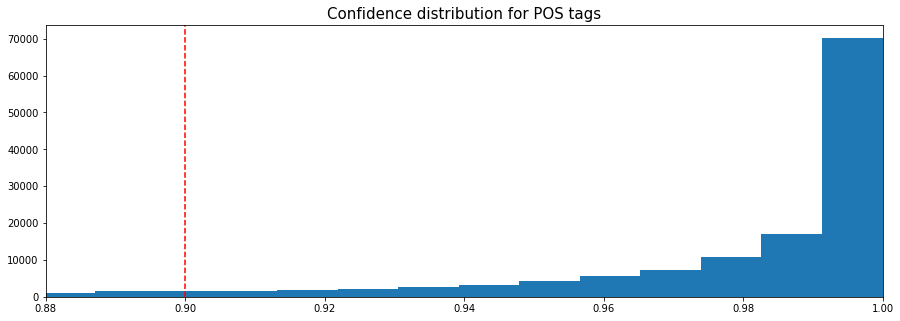

There are 29746 (18.89%) words under 0.90 confidence interval
There will be 127725 (81.11%) words remaining inside 0.90 confidence interval


In [21]:
# Set threshold on confidence
conf = 0.9

# Show confidence distribution
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Confidence distribution for POS tags',fontsize=15)
_ = ax.hist(words.df.entity_conf, bins=100)
_ = ax.set_xlim(left=0.88, right=1.0)
_ = ax.axvline(x=conf, c='r', ls='--')
# _ = plt.savefig('images/preprocessing/tag_conf.png')
_ = plt.show()

# info
print('There are {:d} ({:.02f}%) words under {:.2f} confidence interval'.format(
    sum(words.df.entity_conf < conf), sum(words.df.entity_conf < conf) / words.df.shape[0] * 100, conf
))
# info
print('There will be {:d} ({:.02f}%) words remaining inside {:.2f} confidence interval'.format(
    sum(words.df.entity_conf >= conf), sum(words.df.entity_conf >= conf) / words.df.shape[0] * 100, conf
))

In [22]:
# Filter on confidence
words.df = words.df[words.df.entity_conf >= conf]

In [23]:
# Number of pronouns after cleaning
words.df[words.df.entity_tag == 'O'].shape[0]

13548

In [24]:
# Total number of words extracted 
words.df.shape[0]

127725

In [25]:
# Save words data
if OVERWRITE:
    words.to_json(WORDS_DB_PATH)